In [2]:
from ATARI.theory.resonance_statistics import make_res_par_avg
import ATARI.utils.hdf5 as h5io
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import importlib
import os
from copy import copy
from ATARI.sammy_interface import sammy_classes, sammy_functions, template_creator

from ATARI.models.particle_pair import Particle_Pair
from ATARI.models.experimental_model import experimental_model


In [3]:
%matplotlib widget

In [4]:
### setup the physics and sample a resonance ladder

ac = 0.81271    # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider


energy_range = [200,250]
spin_groups = [ (3.0,1,0)]  # ,  (4.0,1,0)]
res_par_avg_1 = make_res_par_avg(J_ID=1,
                                 D_avg = 4.99, 
                            Gn_avg= 35.5, #0.658, 
                            n_dof = 1, 
                            Gg_avg = 64.0, 
                            g_dof = 1000, 
                            print = False)

average_parameters = {'3.0':res_par_avg_1}
Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={},
                                spin_groups=spin_groups,
                                average_parameters=average_parameters )   

resonance_ladder = Ta_pair.sample_resonance_ladder(energy_range, spin_groups, average_parameters)
resonance_ladder

,E,Gg,Gn1,J,chs,lwave,J_ID
0,203.891048,62.746824,6.234473,3.0,1.0,0.0,1.0
1,208.394212,64.093777,83.279915,3.0,1.0,0.0,1.0
2,214.266113,62.429266,0.553445,3.0,1.0,0.0,1.0
3,215.324452,61.743232,25.841666,3.0,1.0,0.0,1.0
4,222.249275,66.230772,39.091588,3.0,1.0,0.0,1.0
5,229.632687,60.644822,28.893892,3.0,1.0,0.0,1.0
6,230.268828,63.549811,21.102656,3.0,1.0,0.0,1.0
7,233.599141,60.525762,73.157216,3.0,1.0,0.0,1.0
8,237.731895,64.207293,19.438010,3.0,1.0,0.0,1.0
9,248.323376,63.253111,50.980337,3.0,1.0,0.0,1.0


In [5]:
### setup two experimental models
exp_model_T = experimental_model("T12mm", "transmission", [200,250],
                               
                                    parameters={
                                        'FP':(100.14,0.01)
                                        } ,

                                    channel_width_info={
                                          "maxE": [500], 
                                          "chw": [100.0],
                                          "dchw": [0.8]
                                          }
                                                                  )


exp_model_Y = experimental_model("Y1mm", "capture", [200,250],
                               
                                    parameters={
                                        'FP':(100.14,0.01),
                                        't0':(2.0, 0.0)
                                        } ,

                                    channel_width_info={
                                          "maxE": [500], 
                                          "chw": [100.0],
                                          "dchw": [0.8]
                                          }
                                                                  )

exp_model_Y

inputs:
{'alphanumeric': ['USE MULTIPLE SCATTERING', 'INFINITE SLAB', 'NORMALIZE AS YIELD Rather than cross section', 'BROADENING IS WANTED', 'DO NOT SHIFT RPI RESOLUTION'], 'ResFunc': 'RPI C'}
parameters:
{'n': (0.067166, 0.0), 'FP': (100.14, 0.01), 't0': (2.0, 0.0), 'burst': (10, 1.0), 'temp': (300, 0.0)}
channel_width_info:
{'maxE': [500], 'chw': [100.0], 'dchw': [0.8]}

In [6]:
# calculate experimentally corrected transmission or capture yield with sammy

importlib.reload(template_creator)
importlib.reload(sammy_functions)

rto = sammy_classes.sammyRTO('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                             {"Print"   :   True,
                              "bayes"   :   False,
                              "keep_runDIR"     : True
                              })

model = sammy_classes.theory("Ta181", 180.948030, ac=8.1271, formalism="XCT")

template_creator.make_input_template('template_T.inp', model, exp_model_T, rto)
template_creator.make_input_template('template_Y.inp', model, exp_model_Y, rto)

datasets = [exp_model_T.energy_grid,exp_model_Y.energy_grid] 
experiments= [exp_model_T, exp_model_Y] 

templates = [os.path.realpath('template_T.inp'),os.path.realpath('template_Y.inp')]


sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    model = model, 
    resonance_ladder = resonance_ladder,  

    datasets= datasets,
    templates= templates,
    experiments = experiments,
    
    max_steps = 10,
    iterations = 3,
    step_threshold = 0.01,
    autoelim_threshold = None,

    LS = False,
    LevMar = True,
    LevMarV = 2,
    initial_parameter_uncertainty = 1.0
    )


par, lsts = sammy_functions.run_sammy_YW(sammyINPyw, rto)


In [7]:
### define a dataframes to hold the true value with column key 'true' 

true_dfs = []
for i, exp in enumerate(experiments):
    true_df = copy(lsts[i])
    if exp.reaction == "transmission":
        true = "theo_trans"
    elif exp.reaction == "capture":
        true = "theo_xs"
    else:
        raise ValueError()

    true_df = true_df[["E",true]]
    true_df.rename(columns={true:"true"}, inplace=True)

    true_dfs.append(true_df)


In [8]:
### pass true dataframe to syndat 

from ATARI.syndat.transmission_rpi import syndat_T
from ATARI.syndat.yield_rpi import syndat_Y

synT = syndat_T()
synT.run(true_dfs[0])

synY = syndat_Y()
synY.run(true_dfs[1])


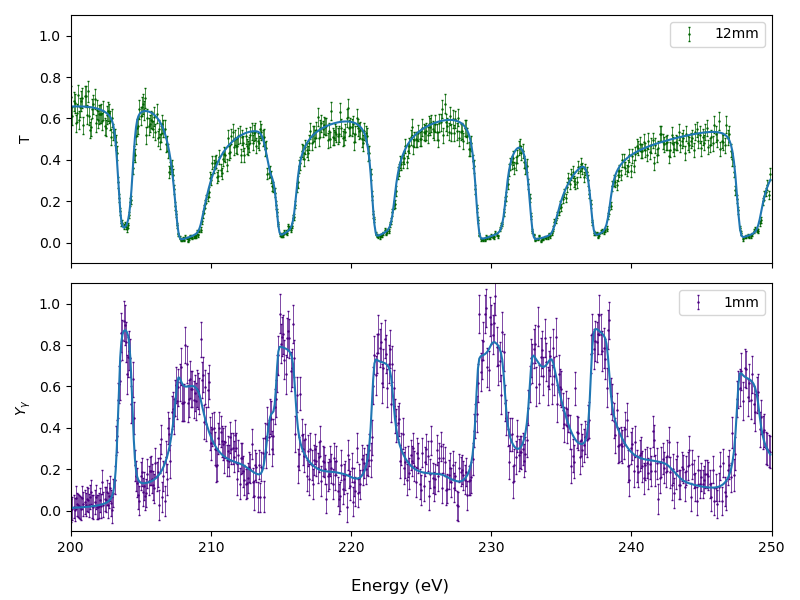

In [9]:
### Plot 

fig, axes = subplots(2,1, figsize=(8,6), sharex=True)

### Trans
axes[0].errorbar(synT.data.E, synT.data.exp, yerr=synT.data.exp_unc, zorder=0,
                                        fmt='.', color='darkgreen', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')

axes[0].plot(synT.data.E, synT.data.true)
axes[0].set_ylabel("T")

### Capture
axes[1].errorbar(synY.data.E, synY.data.exp, yerr=synY.data.exp_unc, zorder=0, 
                                        fmt='.', color='indigo', linewidth=0.5, markersize=1.5, capsize=1, label='1mm')
axes[1].plot(synY.data.E, synY.data.true)

axes[1].set_ylabel(r"$Y_{\gamma}$")

### make it pretty
for ax in axes:
    ax.set_xlim([200,250])
    ax.set_ylim([-0.1,1.1])
    ax.legend()

fig.supxlabel('Energy (eV)')
fig.tight_layout()

## Syndat class

Options:
1. starting from real data or not
2. measurement type (capture, transmission)
3. Sampling options
4. reduction parameters

### Notes
resolution function parameters need not be sampled if true uncertainty because the uncertainty is represented by the experimental model (resolution function) if the parameters were sampled on the generative side then the resolution function would be different for the fit - this would be like testing USU

I'm not sure about n parameter, if this is uncertain, it should be sampled and uncertainty should be propagated in the data reduction - I think this value can be fited in sammy if it is uncertain

Need to add a 'true uncertainty' option:
1. if true: true_underlying_reduction_parameters will be sampled from same mean/std as given by reduction_parameters
2. if false: true_underlying_reduction_parameters will will be samled from different mean/std than given by reduction_parameters

In [10]:

# class syndat:

#     def __init__(self, true: pd.DataFrame, experimental_model):
#         self.true = true
#         self.experimental_model = experimental_model

#         # maybe do some stuff about the energy gridding, maybe I dont need to supply true

#     def run(self, reduction_parameters = {}):


#         if self.experimental_model.reaction == "capture":
#             assert(np.isfinite(self.true.theo_xs))
#             # do capture


#         if self.experimental_model.reaction == "transmission":
#             assert(np.isfinite(self.true.theo_trans))
#             # do transmission

